# __Facial Expression Recognition__

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories 

0. Angry, 
1. Disgust, 
2. Fear, 
3. Happy, 
4. Sad, 
5. Surprise, 
6. Neutral

## Resources:</br>
Data Link: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data</br>
Youtube Tutorials: https://www.youtube.com/watch?v=DtBu1u5aBsc

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop,Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/facial-expression-recognition-challenge-dataset/fer2013.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv


In [2]:
# load the data
df = pd.read_csv("../input/facial-expression-recognition-challenge-dataset/fer2013.csv")

In [3]:
# let's see the first five rows of the dataset
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
# create train, test list to store the trai and test data
# we will iterate through the datafrom df and extract the resprctive values for train and test set
X_train,y_train,X_test,y_test=[],[],[],[]

In [6]:
# Iterate over the dataframe df to extract training and testing data
for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
            X_train.append(np.array(val,'float32'))
            y_train.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
            X_test.append(np.array(val,'float32'))
            y_test.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")

In [7]:
# lets print some train and test data 
print(f"X_train sample data:{X_train[0:2]}")
print(f"X_train sample data:{y_train[0:2]}")
print(f"X_train sample data:{X_test[0:2]}")
print(f"X_train sample data:{y_train[0:2]}")

X_train sample data:[array([ 70.,  80.,  82., ..., 106., 109.,  82.], dtype=float32), array([151., 150., 147., ..., 193., 183., 184.], dtype=float32)]
X_train sample data:[0, 0]
X_train sample data:[array([254., 254., 254., ...,  42., 129., 180.], dtype=float32), array([156., 184., 198., ..., 172., 167., 161.], dtype=float32)]
X_train sample data:[0, 0]


In [8]:
# convert the train and test data into floating point 
X_train = np.array(X_train, 'float32')
y_train = np.array(y_train, 'float32')
X_test = np.array(X_test, 'float32')
y_test = np.array(y_test, 'float32')

In [9]:
# normalize the data, the output will be between 0 and 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

In [14]:
# create some varaible which will be used through out this program
num_features = 64
num_labels = 7 
batch_size = 64
epoch = 200
width, height = 48, 48

In [11]:
# reshape the train, test dataset
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [12]:
# label encoding 
y_train=np_utils.to_categorical(y_train, num_classes=num_labels)
y_test=np_utils.to_categorical(y_test, num_classes=num_labels)

In [13]:
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)       

In [16]:
#Complile the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

In [17]:
#Training the model
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epoch,
          verbose=1,
          shuffle=True)

Epoch 1/200
28709/28709 [==============================] - 14s 482us/step - loss: 1.7209 - accuracy: 0.3145
Epoch 2/200
28709/28709 [==============================] - 9s 322us/step - loss: 1.4774 - accuracy: 0.4259
Epoch 3/200
28709/28709 [==============================] - 9s 314us/step - loss: 1.3620 - accuracy: 0.4757
Epoch 4/200
28709/28709 [==============================] - 9s 311us/step - loss: 1.2861 - accuracy: 0.5079
Epoch 5/200
28709/28709 [==============================] - 9s 319us/step - loss: 1.2268 - accuracy: 0.5323
Epoch 6/200
28709/28709 [==============================] - 10s 333us/step - loss: 1.1723 - accuracy: 0.5548
Epoch 7/200
28709/28709 [==============================] - 9s 316us/step - loss: 1.1293 - accuracy: 0.5687
Epoch 8/200
28709/28709 [==============================] - 9s 313us/step - loss: 1.0880 - accuracy: 0.5840
Epoch 9/200
28709/28709 [==============================] - 9s 320us/step - loss: 1.0491 - accuracy: 0.6003
Epoch 10/200
28709/28709 [=========

In [18]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
score

3589/3589 [==============================] - 1s 167us/step


[2.468238891748772, 0.5982167720794678]

In [19]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("emotion_det_cnn.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("emotion_det_cnn.h5")

## Data Agumentation

In [43]:
# let's check how data agumentation performs
# select one image and try to see the agumented images
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             shear_range=0.3,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

datagen.fit(X_train)

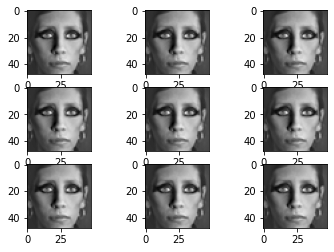

In [36]:
import matplotlib.pyplot as plt
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[4].reshape(48, 48), cmap=plt.get_cmap('gray'))
    
    # show the plot
plt.show()

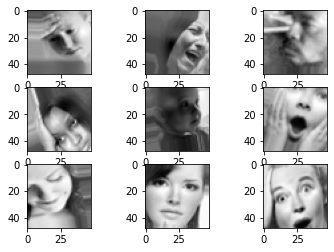

In [44]:
import matplotlib.pyplot as plt
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [48]:
# Define the optimizer
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [49]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                    steps_per_epoch=int(len(X_train) / 64), epochs=200,
                    callbacks=[learning_rate_reduction])


Epoch 1/200
448/448 [==============================] - 17s 38ms/step - loss: 1.2686 - accuracy: 0.5212
Epoch 2/200
448/448 [==============================] - 16s 36ms/step - loss: 1.2683 - accuracy: 0.5248
Epoch 3/200
448/448 [==============================] - 17s 38ms/step - loss: 1.2841 - accuracy: 0.5194
Epoch 4/200
448/448 [==============================] - 16s 36ms/step - loss: 1.2937 - accuracy: 0.5190
Epoch 5/200
448/448 [==============================] - 16s 36ms/step - loss: 1.2888 - accuracy: 0.5201

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/200
448/448 [==============================] - 16s 35ms/step - loss: 1.2606 - accuracy: 0.5256
Epoch 7/200
448/448 [==============================] - 17s 38ms/step - loss: 1.2593 - accuracy: 0.5296
Epoch 8/200
448/448 [==============================] - 16s 35ms/step - loss: 1.2504 - accuracy: 0.5283
Epoch 9/200
448/448 [==============================] - 16s 35ms/step - loss: 1.2577 - accuracy:

In [50]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
score

3589/3589 [==============================] - 1s 155us/step


[9646.123566039461, 0.24937307834625244]

In [51]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("emotion_det_aug.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("emotion_det_aug.h5")

## Data agumentation did not work well to improve the accuracy of the model. I will try to improve this model by training on pre trained model.